In [13]:
from IPython.display import display
from dominance_analysis import Dominance
import pandas as pd
import statsmodels.api as sm
import shap


In [24]:
# restart your Jupyter kernel, then in a new cell:
import pandas as pd
import matplotlib.pyplot as plt

# 1) load the cleaned, final panel
df = pd.read_parquet("data/processed/wide_panel.parquet")

# 2) quick sanity‐check
print(df.columns.tolist())
print(df.isna().sum())
df.head()


['date', 'date_id', 'real_gdp', 'ict_inv', 'priv_rd', 'recession_dummy', 'unemp_rate', 'cpi', 'fedfunds', 'lfpr', 'rd_gdp', 'ict_gdp', 'gdp_g', 'ict_g', 'rd_g', 'ict_share_g', 'rd_share_g', 'unemp_rate_g', 'inflation_g', 'fedfunds_g', 'lfpr_g']
date                0
date_id             0
real_gdp            0
ict_inv             0
priv_rd             0
recession_dummy     0
unemp_rate          3
cpi                 0
fedfunds           29
lfpr                3
rd_gdp              0
ict_gdp             0
gdp_g               0
ict_g               0
rd_g                0
ict_share_g         0
rd_share_g          0
unemp_rate_g        4
inflation_g         0
fedfunds_g         30
lfpr_g              4
dtype: int64


,date,date_id,real_gdp,ict_inv,priv_rd,recession_dummy,unemp_rate,cpi,fedfunds,lfpr,...,ict_gdp,gdp_g,ict_g,rd_g,ict_share_g,rd_share_g,unemp_rate_g,inflation_g,fedfunds_g,lfpr_g
0,1947-04-01,194702,2176.892,1.664,11.3276,0.0,NaN,22.0100,NaN,NaN,...,0.000764,-0.002652,-0.026331,0.022790,-0.023742,0.025510,NaN,0.000000,NaN,NaN
1,1947-07-01,194703,2172.432,1.770,11.6350,0.0,NaN,22.4900,NaN,NaN,...,0.000815,-0.002049,0.063702,0.027137,0.065886,0.029246,NaN,0.006793,NaN,NaN
2,1947-10-01,194704,2206.452,1.749,12.1179,0.0,NaN,23.1267,NaN,NaN,...,0.000793,0.015660,-0.011864,0.041504,-0.027100,0.025446,NaN,0.003065,NaN,NaN
3,1948-01-01,194801,2239.682,1.831,11.6520,0.0,3.7333,23.6167,NaN,58.6667,...,0.000818,0.015060,0.046884,-0.038447,0.031351,-0.052714,NaN,0.011534,NaN,NaN
4,1948-04-01,194802,2276.690,1.759,11.6928,0.0,3.6667,23.9933,NaN,58.8333,...,0.000773,0.016524,-0.039323,0.003502,-0.054939,-0.012811,-0.025,0.013617,NaN,0.008547


In [14]:
print(df.columns.tolist())

['date', 'date_id', 'real_gdp', 'ict_inv', 'priv_rd', 'rd_gdp', 'ict_gdp', 'gdp_g', 'ict_g', 'rd_g', 'ict_share_g', 'rd_share_g']


In [3]:
import numpy as np

# 2. drop any rows where a level is missing
df = df.dropna(subset=["real_gdp","ict_inv","priv_rd"])

# 3. compute pct‐changes
df["gdp_g"]  = df["real_gdp"].pct_change()
df["ict_g"]  = df["ict_inv"].pct_change()
df["rd_g"]   = df["priv_rd"].pct_change()

# 4. turn infinities into NaN
df[["gdp_g","ict_g","rd_g"]] = df[["gdp_g","ict_g","rd_g"]].replace([np.inf, -np.inf], np.nan)

# 5. drop any rows where a growth rate is still missing
df = df.dropna(subset=["gdp_g","ict_g","rd_g"])

print("Cleaned panel — final sample size:", len(df))


Cleaned panel — final sample size: 311


In [7]:
print(df.columns)


Index(['date', 'date_id', 'real_gdp', 'ict_inv', 'priv_rd', 'rd_gdp',
       'ict_gdp', 'gdp_g', 'ict_g', 'rd_g', 'ict_share_g', 'rd_share_g',
       'gdp_g_4q', 'ict_g_4q', 'rd_g_4q', 'ict_share_g_4q', 'rd_share_g_4q'],
      dtype='object')


Text(0, 0.5, 'Pct. Change')

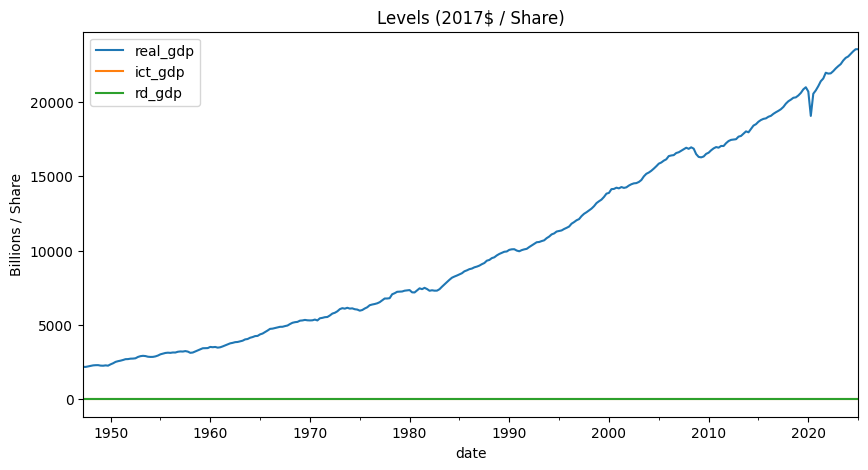

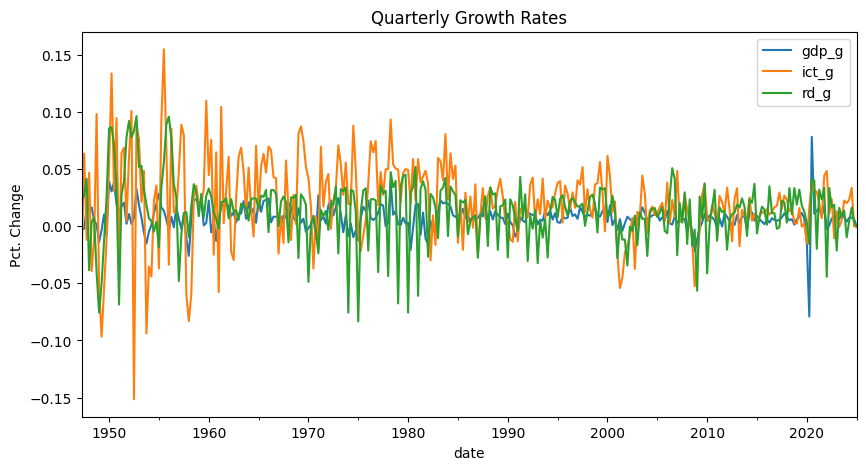

In [25]:
# Levels
ax = df.set_index("date")[["real_gdp","ict_gdp","rd_gdp"]] \
       .plot(title="Levels (2017$ / Share)", figsize=(10,5))
ax.set_ylabel("Billions / Share")

# Quarterly growth
ax2 = df.set_index("date")[["gdp_g","ict_g","rd_g"]] \
        .plot(title="Quarterly Growth Rates", figsize=(10,5))
ax2.set_ylabel("Pct. Change")


In [26]:
# 1) 4-quarter rolling means
for col in ['gdp_g','ict_g','rd_g','ict_share_g','rd_share_g']:
    df[f"{col}_4q"] = df[col].rolling(4, center=True).mean()

# 2) annualize: end-of-year + (1+q)^4−1
df_yr = df.set_index("date").resample('A').last()
for col in ['gdp_g','ict_g','rd_g','ict_share_g','rd_share_g']:
    df_yr[f"{col}_ann"] = (1 + df_yr[col])**4 - 1

df_yr[[c for c in df_yr.columns if c.endswith('_ann')]].head()


,gdp_g_ann,ict_g_ann,rd_g_ann,ict_share_g_ann,rd_share_g_ann
date,,,,,
1947-12-31,0.064126,-0.046620,0.176641,-0.104072,0.105734
1948-12-31,0.004539,0.455542,-0.152998,0.448965,-0.156825
1949-12-31,-0.033093,-0.048322,0.104724,-0.015749,0.142534
1950-12-31,0.078827,0.436515,0.141667,0.331553,0.058249
1951-12-31,0.008787,0.017889,0.350354,0.009022,0.338592


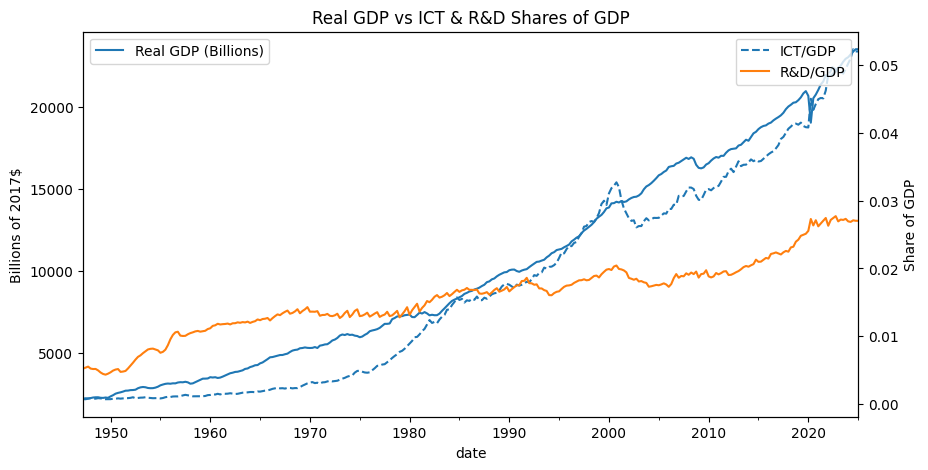

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))

# plot real GDP on left axis
df.plot(x='date', y='real_gdp', ax=ax, label='Real GDP (Billions)')

# twin axis for shares
ax2 = ax.twinx()
df.plot(x='date',
        y=['ict_gdp','rd_gdp'],
        ax=ax2,
        label=['ICT/GDP','R&D/GDP'],
        style=['--','-'],
        legend=False)

ax.set_ylabel("Billions of 2017$")
ax2.set_ylabel("Share of GDP")
ax.set_title("Real GDP vs ICT & R&D Shares of GDP")
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()


In [46]:
# set the index and take each year's last quarter
df_yr = df.set_index('date').resample('A').last()

# convert quarterly pct‐changes into annual rates
for col in ['gdp_g','ict_g','rd_g','ict_share_g','rd_share_g']:
    df_yr[f'{col}_ann'] = (1 + df_yr[col])**4 - 1

df_yr[[c+'_ann' for c in ['gdp_g','ict_g','rd_g','ict_share_g','rd_share_g']]].head()


/var/folders/1r/553vqt_57l76376t4wbt5pjc0000gn/T/ipykernel_2991/3937688173.py:2: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yr = df.set_index('date').resample('A').last()


,gdp_g_ann,ict_g_ann,rd_g_ann,ict_share_g_ann,rd_share_g_ann
date,,,,,
1947-12-31,0.064126,-0.046620,0.176641,-0.104072,0.105734
1948-12-31,0.004539,0.455542,-0.152998,0.448965,-0.156825
1949-12-31,-0.033093,-0.048322,0.104724,-0.015749,0.142534
1950-12-31,0.078827,0.436515,0.141667,0.331553,0.058249
1951-12-31,0.008787,0.017889,0.350354,0.009022,0.338592


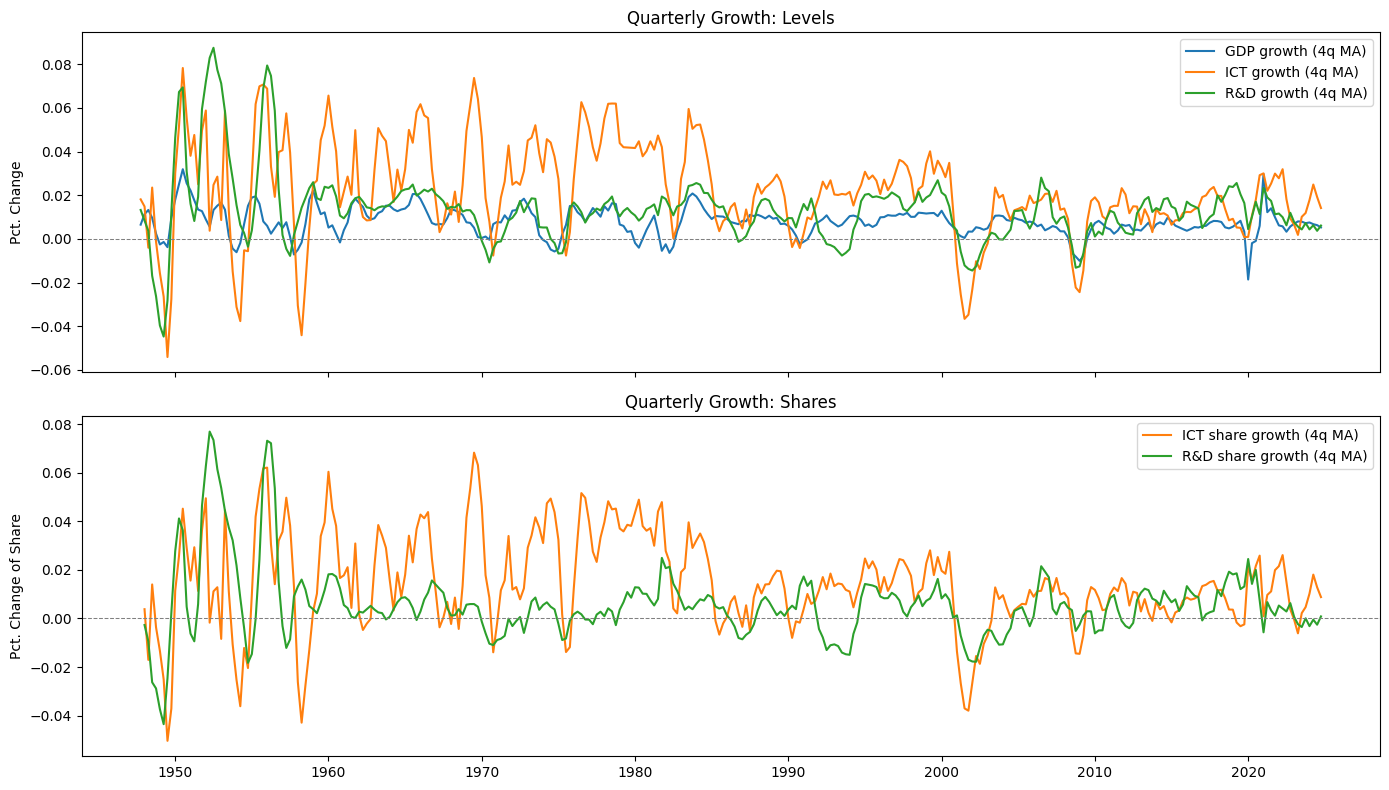

In [8]:
import matplotlib.pyplot as plt

colors = {
    'gdp': '#1f77b4',   # blue
    'ict': '#ff7f0e',   # orange
    'rnd': '#2ca02c'    # green
}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Top chart — Levels
ax1.plot(df['date'], df['gdp_g_4q'], label='GDP growth (4q MA)', color=colors['gdp'])
ax1.plot(df['date'], df['ict_g_4q'], label='ICT growth (4q MA)', color=colors['ict'])
ax1.plot(df['date'], df['rd_g_4q'], label='R&D growth (4q MA)', color=colors['rnd'])
ax1.axhline(0, linestyle='--', color='gray', linewidth=0.75)
ax1.set_ylabel('Pct. Change')
ax1.set_title('Quarterly Growth: Levels')
ax1.legend()

# Bottom chart — Shares
ax2.plot(df['date'], df['ict_share_g_4q'], label='ICT share growth (4q MA)', color=colors['ict'])
ax2.plot(df['date'], df['rd_share_g_4q'], label='R&D share growth (4q MA)', color=colors['rnd'])
ax2.axhline(0, linestyle='--', color='gray', linewidth=0.75)
ax2.set_ylabel('Pct. Change of Share')
ax2.set_title('Quarterly Growth: Shares')
ax2.legend()

plt.tight_layout()
plt.show()


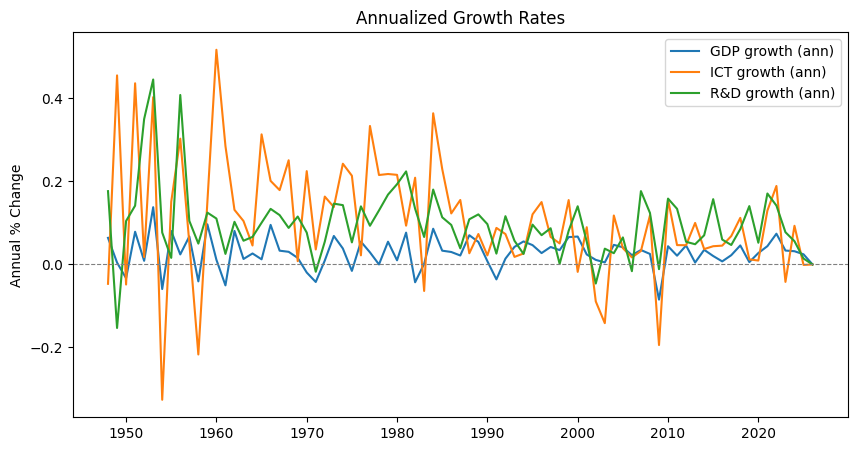

In [49]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df_yr.index, df_yr['gdp_g_ann'],  label='GDP growth (ann)')
ax.plot(df_yr.index, df_yr['ict_g_ann'],  label='ICT growth (ann)')
ax.plot(df_yr.index, df_yr['rd_g_ann'],   label='R&D growth (ann)')
ax.axhline(0, color='gray', linewidth=0.8, linestyle='--')
ax.set_ylabel("Pct. change")
ax.set_title("Quarterly Growth Rates")
ax.set_title("Annualized Growth Rates")
ax.set_ylabel("Annual % Change")
ax.legend()
plt.show()


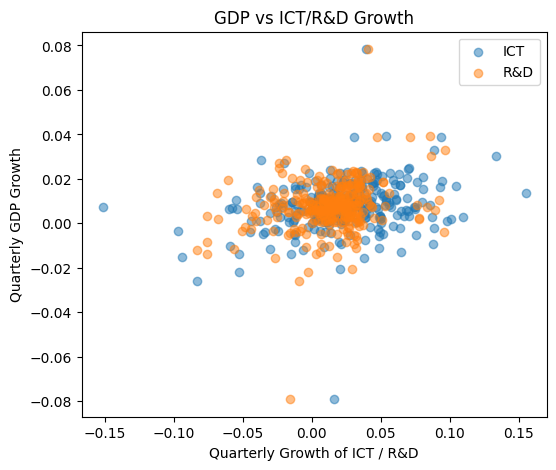

corr(GDP, ICT) = 0.26006795778255515
corr(GDP, R&D) = 0.25830660660748567


In [27]:
# scatter
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(df.ict_g, df.gdp_g, alpha=0.5, label='ICT')
ax.scatter(df.rd_g,  df.gdp_g, alpha=0.5, label='R&D')
ax.set_xlabel("Quarterly Growth of ICT / R&D")
ax.set_ylabel("Quarterly GDP Growth")
ax.legend()
ax.set_title("GDP vs ICT/R&D Growth")
plt.show()

# correlations
print("corr(GDP, ICT) =", df.gdp_g.corr(df.ict_g))
print("corr(GDP, R&D) =", df.gdp_g.corr(df.rd_g))


In [28]:
import statsmodels.api as sm

X = sm.add_constant(df[['ict_g','rd_g','recession_dummy']])
y = df['gdp_g']
res = sm.OLS(y, X, missing='drop').fit(cov_type='HC1')
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:                  gdp_g   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     35.17
Date:                Wed, 30 Apr 2025   Prob (F-statistic):           1.43e-19
Time:                        07:21:33   Log-Likelihood:                 1006.6
No. Observations:                 312   AIC:                            -2005.
Df Residuals:                     308   BIC:                            -1990.
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0082      0.001     

In [55]:
import statsmodels.api as sm

# load your panel
df = pd.read_parquet("data/processed/wide_panel.parquet")

# drop any remaining NaNs
df = df.dropna(subset=['gdp_g','ict_g','rd_g'])

# regress gdp_g on ICT and R&D growth
X = sm.add_constant(df[['ict_g','rd_g']])
y = df.gdp_g

ols = sm.OLS(y, X).fit(cov_type='HC1')
print(ols.summary())


                            OLS Regression Results                            
Dep. Variable:                  gdp_g   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     13.87
Date:                Wed, 30 Apr 2025   Prob (F-statistic):           1.70e-06
Time:                        02:59:48   Log-Likelihood:                 978.11
No. Observations:                 312   AIC:                            -1950.
Df Residuals:                     309   BIC:                            -1939.
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.001      6.691      0.0

In [13]:
from dominance_analysis import Dominance
import pandas as pd
import statsmodels.api as sm

# Load your data
df = pd.read_parquet("data/processed/wide_panel.parquet")

# Set up predictors and target
X = df[['ict_g', 'rd_g']]
y = df['gdp_g']

# Combine into one DataFrame
data = pd.concat([y, X], axis=1)

# Run dominance analysis
dom = Dominance(data=data, target='gdp_g')
results = dom.incremental_rsquare()

print(results)


Selecting 2 Best Predictors for the Model
Selected Predictors :  ['ict_g', 'rd_g']

********************  R-Squared of Complete Model :  ********************
R Squared : 0.10937388464116005

Selecting 2 Best Predictors for the Model
Selected Predictors :  ['ict_g', 'rd_g']

Creating models for 3 possible combinations of 2 features :


100%|██████████| 2/2 [00:00<00:00, 97.46it/s]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|██████████| 1/1 [00:00<00:00, 10230.01it/s]

#########################  Variable Dominance Calculation Done!!!!!  #########################

{'ict_g': 0.05514346214463728, 'rd_g': 0.05423042249652277}


In [29]:
from dominance_analysis import Dominance

da = Dominance(
    data=pd.concat([df[['ict_g','rd_g','recession_dummy']],
                    df.gdp_g.rename('gdp_g')], axis=1),
    dependent_variable='gdp_g'
)
print(da.incremental_rsquare().summary())


TypeError: Dominance.__init__() got an unexpected keyword argument 'dependent_variable'

In [4]:
import pandas as pd

# Load the panel
df = pd.read_parquet("data/processed/wide_panel.parquet")

# Load & merge control variables from clean FRED .parquet files
def load_and_merge(df, path, original_colname, new_colname, percent_change=True):
    temp = pd.read_parquet(path)
    if original_colname not in temp.columns:
        print(f"❌ '{original_colname}' not found in {path}")
        return df
    temp = temp.rename(columns={original_colname: new_colname})
    if percent_change:
        temp[new_colname] = temp[new_colname].pct_change()
    return df.merge(temp[['date', new_colname]], on='date', how='left')
df = load_and_merge(df, "data/clean/fred_COMPRNFB.parquet", "COMPRNFB", "consumption_g")
df = load_and_merge(df, "data/clean/fred_UNRATE.parquet", "UNRATE", "unemp_rate_g")
df = load_and_merge(df, "data/clean/fred_CPIAUCSL.parquet", "CPIAUCSL", "inflation_g")
df = load_and_merge(df, "data/clean/fred_FEDFUNDS.parquet", "FEDFUNDS", "fedfunds_g")
df = load_and_merge(df, "data/clean/fred_CIVPART.parquet", "CIVPART", "lfpr_g")
df = load_and_merge(df, "data/clean/fred_USREC.parquet", "USREC", "recession", percent_change=False)


In [19]:
df.columns[df.columns.str.endswith('_g') | (df.columns == 'recession')].tolist()

['gdp_g',
 'ict_g',
 'rd_g',
 'ict_share_g',
 'rd_share_g',
 'consumption_g',
 'unemp_rate_g',
 'inflation_g',
 'fedfunds_g',
 'lfpr_g',
 'recession']

/usr/local/lib/python3.11/site-packages/shap/explainers/_linear.py:99: FutureWarning:

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).



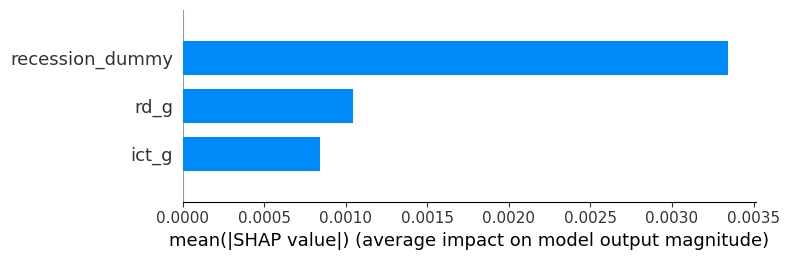

In [30]:
import shap
from sklearn.linear_model import LinearRegression

# fit a linear model
X = df[['ict_g','rd_g','recession_dummy']]
y = df['gdp_g']
model = LinearRegression().fit(X, y)

# explainer (choose one perturbation mode)
explainer = shap.LinearExplainer(model, X, feature_perturbation="interventional")
shap_vals = explainer.shap_values(X)

# bar plot of mean(|shap|)
shap.summary_plot(shap_vals, X, plot_type="bar")


In [23]:
X = df_clean[features]
y = df_clean['gdp_g']

from dominance_analysis import Dominance
dom = Dominance(data=pd.concat([y, X], axis=1), target='gdp_g')
results = dom.incremental_rsquare()

print("R² contributions:")
print(results)


Selecting 8 Best Predictors for the Model
Selected Predictors :  ['ict_g', 'rd_g', 'consumption_g', 'unemp_rate_g', 'inflation_g', 'fedfunds_g', 'lfpr_g', 'recession']

********************  R-Squared of Complete Model :  ********************
R Squared : 0.4726661842283699

Selecting 8 Best Predictors for the Model
Selected Predictors :  ['ict_g', 'rd_g', 'consumption_g', 'unemp_rate_g', 'inflation_g', 'fedfunds_g', 'lfpr_g', 'recession']

Creating models for 255 possible combinations of 8 features :


100%|██████████| 8/8 [00:00<00:00,  8.79it/s]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|██████████| 7/7 [00:00<00:00, 324.75it/s]

#########################  Variable Dominance Calculation Done!!!!!  #########################

R² contributions:
{'ict_g': 0.019911320122914827, 'rd_g': 0.01584922267231738, 'consumption_g': 0.0167423770809466, 'unemp_rate_g': 0.20759827832008199, 'inflation_g': 0.002460013414565654, 'fedfunds_g': 0.026278150103097503, 'lfpr_g': 0.025789325162584475, 'recession': 0.15803749735186148}


In [10]:
import shap
from sklearn.linear_model import LinearRegression

# 1) fit your model
X = df[['ict_g','rd_g','recession_dummy']]
y = df['gdp_g']
model = LinearRegression().fit(X, y)

# 2) use one of the two built-in SHAP perturbation modes:
explainer = shap.LinearExplainer(
    model,
    X,
    feature_perturbation="interventional"    # or "correlation_dependent"
)
shap_values = explainer.shap_values(X)


/usr/local/lib/python3.11/site-packages/shap/explainers/_linear.py:99: FutureWarning:

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).



unemp_rate_g       0.454658
recession_dummy    0.303012
rd_g               0.138608
ict_g              0.103723
dtype: float64


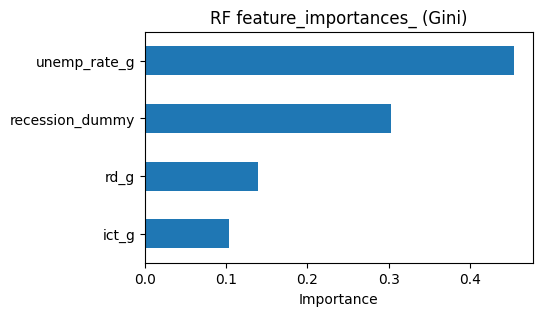

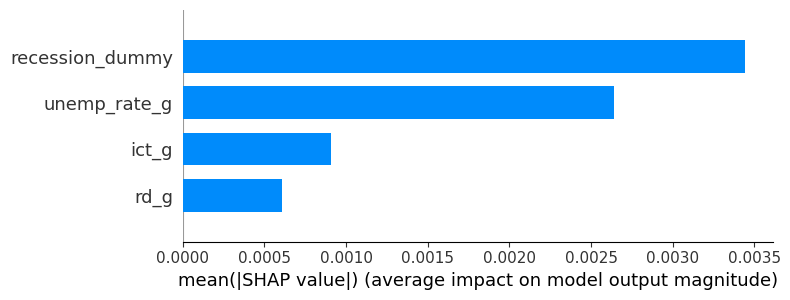

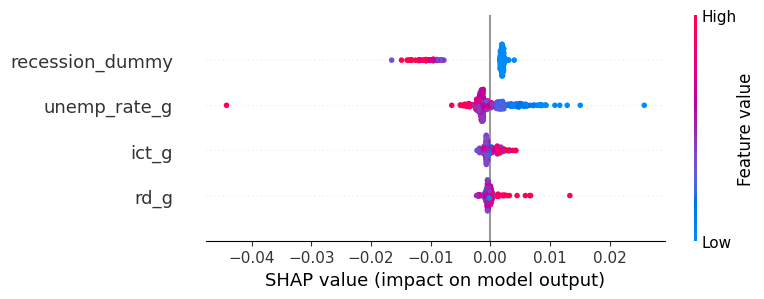

In [33]:
from sklearn.ensemble import RandomForestRegressor

# drop any NaNs in your predictors + target
df_rf = df[['ict_g','rd_g','recession_dummy','unemp_rate_g','inflation_g','gdp_g']].dropna()

X_rf = df_rf[['ict_g','rd_g','recession_dummy','unemp_rate_g']]
y_rf = df_rf['gdp_g']

# 1) sklearn feature_importances_
rf = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=1)
rf.fit(X_rf, y_rf)
# 1) raw sklearn importances
imp = pd.Series(rf.feature_importances_, index=X_rf.columns)
print(imp.sort_values(ascending=False))
imp.sort_values().plot.barh(figsize=(5,3),
    title="RF feature_importances_ (Gini)") 
plt.xlabel("Importance")
plt.show()

imp = pd.Series(rf.feature_importances_, index=X_rf.columns)
imp.sort_values().plot.barh(figsize=(5,3), title="RF feature_importances_")

# 2) SHAP for the forest
explainer_rf = shap.TreeExplainer(rf)
shap_vals_rf = explainer_rf.shap_values(X_rf)
shap.summary_plot(shap_vals_rf, X_rf, plot_type="bar")

# 2) full SHAP beeswarm
shap.summary_plot(shap_vals_rf, X_rf)



In [18]:
# 1) load your panel
df = pd.read_parquet("data/processed/wide_panel.parquet")

# 2) sanity‐check which predictors you actually have
wanted = ['ict_g','rd_g','recession_dummy','unemp_rate']
present = df.columns.intersection(wanted).tolist()
missing = set(wanted) - set(present)
print("Present:", present)
print("Missing:", missing)

# 3) only build X from the columns that exist
X = df[present]
y = df['gdp_g']


# after you build X and y:

# 1️⃣ glue X and y together...
df_xy = pd.concat([X, y.rename('gdp_g')], axis=1)

# 2️⃣ drop any rows where *any* of your predictors or the target is NaN
df_xy = df_xy.dropna()

# 3️⃣ split back out
X_clean = df_xy[X.columns]
y_clean = df_xy['gdp_g']

# 4️⃣ now it will fit
rf.fit(X_clean, y_clean)



Present: ['recession_dummy', 'unemp_rate', 'ict_g', 'rd_g']
Missing: set()


RandomForestRegressor(max_depth=5, n_estimators=200, random_state=1)

Present predictors: ['recession_dummy', 'ict_g', 'rd_g']
Missing (dropped): {'inflation_g', 'unemp_rate_g'}


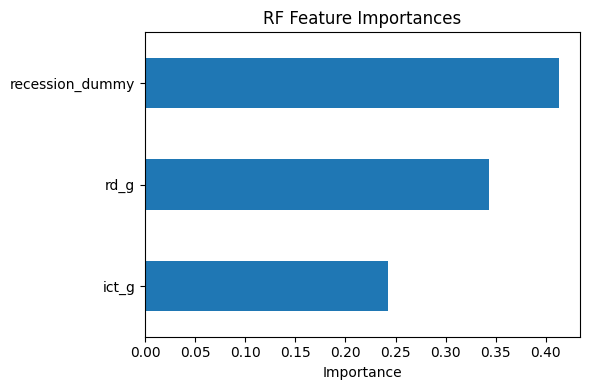

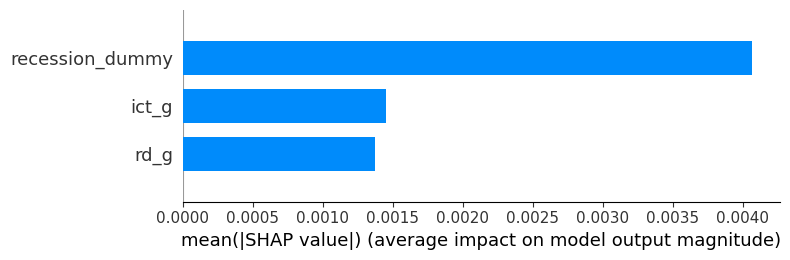

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import shap

# 1) Load your cleaned panel
df = pd.read_parquet("data/processed/wide_panel.parquet")

# 2) Pick only the predictors that exist
wanted = ['ict_g','rd_g','recession_dummy','unemp_rate_g','inflation_g']
present = df.columns.intersection(wanted).tolist()
missing = set(wanted) - set(present)
print("Present predictors:", present)
if missing:
    print("Missing (dropped):", missing)

X = df[present]
y = df['gdp_g']

# 3) Drop any rows with NaNs in predictors or the target
df_xy = pd.concat([X, y.rename('gdp_g')], axis=1).dropna()
X_clean = df_xy[present]
y_clean = df_xy['gdp_g']

# 4) Fit the Random Forest
rf = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=1)
rf.fit(X_clean, y_clean)

# 5) Plot sklearn feature_importances_
imp = pd.Series(rf.feature_importances_, index=X_clean.columns)
imp.sort_values().plot.barh(figsize=(6,4), title="RF Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# 6) (Optional) SHAP summary plot
explainer_rf = shap.TreeExplainer(rf)
shap_vals_rf = explainer_rf.shap_values(X_clean)
shap.summary_plot(shap_vals_rf, X_clean, plot_type="bar")


In [23]:
import pandas as pd
cpi = pd.read_parquet("data/clean/fred_CIVPART.parquet")
print(cpi.columns)


Index(['date', 'CIVPART'], dtype='object')
